In [1]:
import torch
import random
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import torch.nn as nn
import torch.nn.functional as F
import torch.optim

import math
import time
import os
import random

import sys
sys.path.insert(0,'..')

/scratch/cluster/bodeng/miniconda3/envs/dip/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


# 1. Load the data and get measurements

In [3]:
ROOT_PATH = "/scratch/cluster/bodeng/UTAFSDataNew/new_data"
CHIP_NUM = 5

In [4]:
import utils

data_dict = utils.grab_chip_data(ROOT_PATH, CHIP_NUM)

In [5]:
data_dict.keys()

dict_keys(['gt_matrix', 'gt_freqs', 'vf_matrix', 'y_matrix', 'y_freqs'])

## Convert the raw data matrices to only the unique S-parameters

In [6]:
vf_data = utils.matrix_to_sparams(data_dict['vf_matrix'])
gt_data = utils.matrix_to_sparams(data_dict['gt_matrix'])
y_data = utils.matrix_to_sparams(data_dict['y_matrix'])

print("VF S-parameters shape: ", vf_data.shape)
print("GT S-parameters shape: ", gt_data.shape)
print("Y S-parameters shape: ", y_data.shape)

VF S-parameters shape:  (10, 2, 1001)
GT S-parameters shape:  (10, 2, 1001)
Y S-parameters shape:  (10, 2, 10)


In [7]:
gt_freqs = data_dict['gt_freqs']
y_freqs = data_dict['y_freqs']

print("GT frequencies shape: ", gt_freqs.shape)
print("Y frequencies shape: ", y_freqs.shape)

GT frequencies shape:  (1001,)
Y frequencies shape:  (10,)


In [8]:
import scipy as sp

spacings = gt_freqs[1:] - gt_freqs[:-1]

mode_spacing = sp.stats.mode(spacings, keepdims=False)[0]
num_mode = len(np.where(spacings==mode_spacing)[0])

print("First frequency point: ", gt_freqs[0])
print("Mean frequency spacing: ", np.mean(spacings))
print("STD frequency spacing: ", np.std(spacings))
print("Mode frequency spacing: ", mode_spacing)
print("Number of samples with non-equal spacing: ", len(gt_freqs) - num_mode)

First frequency point:  1000000.0
Mean frequency spacing:  19999000.0
STD frequency spacing:  0.0
Mode frequency spacing:  19999000.0
Number of samples with non-equal spacing:  1


In [9]:
#NOTE THIS IS EXPERIMENTAL!!!
if gt_freqs[0] == 0:
    gt_freqs = gt_freqs[1:]
    gt_data = gt_data[:, :, 1:]

## Make some variables we will need

In [10]:
N_FREQS = gt_data.shape[-1]
N_SPARAMS = gt_data.shape[0]  

print("N_FREQS: ", N_FREQS)
print("N_SPARAMS: ", N_SPARAMS)

N_FREQS:  1001
N_SPARAMS:  10


In [11]:
x = torch.from_numpy(gt_data).view(-1, N_FREQS).unsqueeze(0).to(device)

print("x shape: ", x.shape)

x shape:  torch.Size([1, 20, 1001])


In [12]:
x_mag = utils.sparams_to_mag(x)

print("x_mag shape: ", x_mag.shape)

x_mag shape:  torch.Size([1, 10, 1001])


## Plot some stuff

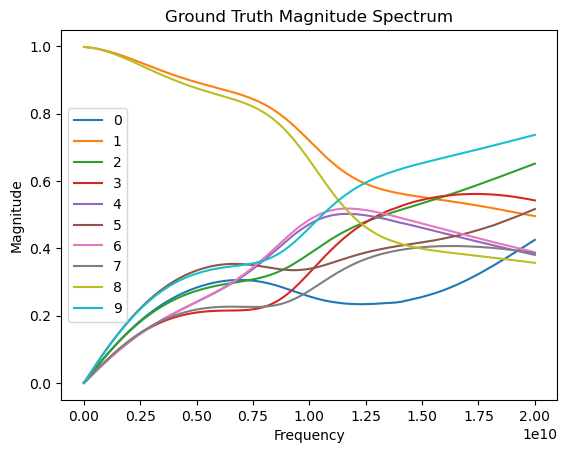

In [13]:
plt.figure()
for i in range(N_SPARAMS):
    plt.plot(gt_freqs, x_mag[0, i].cpu(), label=str(i))
if N_SPARAMS <= 10:
    plt.legend()
plt.title("Ground Truth Magnitude Spectrum")
plt.ylabel("Magnitude")
plt.xlabel("Frequency")
plt.show()

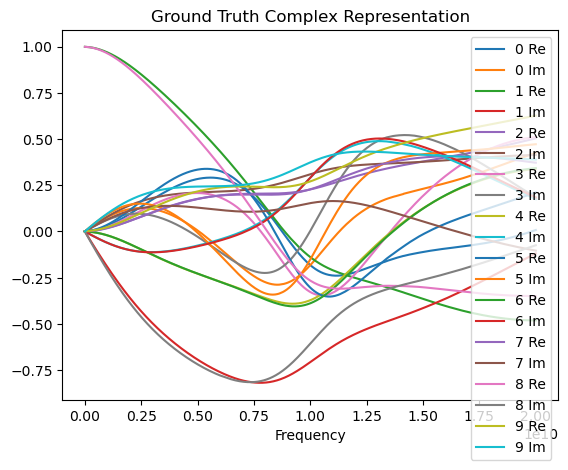

In [14]:
plt.figure()
for i in range(N_SPARAMS):
    plt.plot(gt_freqs, x[0,2*i].cpu(), label=str(i)+" Re")
    plt.plot(gt_freqs, x[0,2*i+1].cpu(), label=str(i)+" Im")
if N_SPARAMS <= 10:
    plt.legend()
plt.title("Ground Truth Complex Representation")
plt.xlabel("Frequency")
plt.show()

## Grab Some Measurements

In [15]:
PROBLEM_TYPE = "equal" #[random, equal, forecast, full, log, sqrt]
# M = int(0.10 * N_FREQS)
M = 10

kept_inds, missing_inds = utils.get_inds(PROBLEM_TYPE, N_FREQS, M)
old_kept = kept_inds.copy()

M = len(kept_inds) #re-define in case kept_inds is off by 1 or something

# remove every other point, starting at the back, don't remove first point
remove = False
for i in range(len(kept_inds) - 1, 0, -1):
    if remove:
        kept_inds = np.delete(kept_inds, [i])
        remove = False
    else:
        remove = True


print("Number of Ground Truth Frequency Points: ", N_FREQS)
print("Number of Measurements: ", M)
print("Undersampling Ratio: ", M/N_FREQS)
print(kept_inds)
print(old_kept)

Number of Ground Truth Frequency Points:  1001
Number of Measurements:  10
Undersampling Ratio:  0.00999000999000999
[   0  111  333  555  777 1000]
[   0  111  222  333  444  555  666  777  888 1000]


In [16]:
y = torch.clone(x)[:, :, kept_inds]
y_freqs = gt_freqs[kept_inds]

print("y shape: ", y.shape)
print("y_freqs shape: ", y_freqs.shape)

y shape:  torch.Size([1, 20, 6])
y_freqs shape:  (6,)


# 2. Network Setup

## Define network parameters

In [17]:
NZ = y.shape[1]

NUM_LAYERS = int(np.ceil(np.log2(N_FREQS))) - 4

if NZ < 64:
    BASE_NGF = 2 ** (int(np.ceil(np.log2(NZ))) + 1) #second power of two after NZ 
elif NZ < 128:
    BASE_NGF = 2 ** int(np.ceil(np.log2(NZ))) #next highest power of 2
else:
    BASE_NGF = NZ

NGF = [BASE_NGF] * NUM_LAYERS

BS = y.shape[0]
NC = y.shape[1]

KERNEL_SIZE = 3
USE_SKIP = False
CAUSAL_PASSIVE = True
OPTIMIZE_Z = False
USE_SGLD = True

In [18]:
print("NZ: ", str(NZ))
print("NUM_LAYERS: ", str(NUM_LAYERS))
print("BASE NGF: ", str(BASE_NGF))
print("NGF: ", str(NGF))
print("BS: ", BS)
print("NC: ", NC)
print("KERNEL_SIZE: ", KERNEL_SIZE)
print("USE_SKIP: ", USE_SKIP)
print("CAUSAL_PASSIVE: ", CAUSAL_PASSIVE)
print("OPTIMIZE_Z: ", OPTIMIZE_Z)

NZ:  20
NUM_LAYERS:  6
BASE NGF:  64
NGF:  [64, 64, 64, 64, 64, 64]
BS:  1
NC:  20
KERNEL_SIZE:  3
USE_SKIP:  False
CAUSAL_PASSIVE:  True
OPTIMIZE_Z:  False


## Init and check dimensions

In [19]:
from models import RES_UNET

net = RES_UNET(bs=BS,
               nz=NZ,
               ngf=NGF,
               output_size=N_FREQS,
               nc=NC,
               optimize_z=OPTIMIZE_Z,
               kernel_size=KERNEL_SIZE,
               num_layers=NUM_LAYERS,
               use_skip=USE_SKIP,
               causal_passive=CAUSAL_PASSIVE,
               p_dropout=0.25
               )
net = net.to(device)

In [20]:
test_out = net.forward_with_z()

print("Net output shape: ", test_out.shape)

Net output shape:  torch.Size([1, 20, 1001])


/scratch/cluster/bodeng/miniconda3/envs/dip/lib/python3.9/site-packages/torch/nn/functional.py:1338: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d instead.
  warnings.warn("dropout2d: Received a 3D input to dropout2d and assuming that channel-wise "


In [21]:
pytorch_total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)

print("TOTAL PARAMS: ", pytorch_total_params)

TOTAL PARAMS:  349384


# 3. Run

## Define training parameters, losses, and track stats

In [22]:
#grab the correct file we want for VF
NUM_ACTIVE = M - len(kept_inds)

LR = 2e-4
FIRST_ITER = 20000
NUM_ITER = 2000
TOTAL_ITERS = FIRST_ITER + NUM_ITER * NUM_ACTIVE
NUM_BURN_ITER = FIRST_ITER * 0 # TODO: use whatever value varun says is good
CURR_ITER = FIRST_ITER
SAMPLE_EVERY = 4

ACTIVE_ITER_RATIO = 0.1
SAMPLE_LAST_N = 200

# TODO: maybe come back to this?
# TOTAL_ITER = NUM_ITER + 0.1 * NUM_ACTIVE * NUM_ITER

REG_HYPERPARAM = 1.0
NOISY_INPUT = True
USE_SGLD = False

if REG_HYPERPARAM > 0:
    regularizer = utils.Smoothing_Loss(per_param=False, reduction="sum")
    regularizer = regularizer.to(device)

optim = torch.optim.Adam(net.parameters(), lr=LR)

def get_lr(optim):
    for g in optim.param_groups:
        return g['lr']
    
def set_lr(optim, lr):
    for g in optim.param_groups:
        g['lr'] = lr
        
START_NOISE_LEVEL = CUR_NOISE_LEVEL = 1.0
END_NOISE_LEVEL = 0.001
NOISE_DECAY_FACTOR = (END_NOISE_LEVEL / START_NOISE_LEVEL)**(1 / TOTAL_ITERS) 

train_losses = []
train_errors = []
if REG_HYPERPARAM > 0:
    train_regs = []

test_mses = []
test_maes = []

is_initial_fit = True
tic = time.time()
net.train()

# (NUM_ACTIVE + 1) * NUM_OUTPUTS * S_PARAMS * FREQS
sgld_outputs_by_sample = []
# (NUM_ACTIVE + 1) * S_PARAMS * FREQS
sgld_means_by_sample = []
# (NUM_ACTIVE + 1) * S_PARAMS * FREQS
sgld_stds_by_sample = []

for num_actively_sampled in range(NUM_ACTIVE + 1):

    cur_sgld_outputs = torch.Tensor().to(device)   

    if not is_initial_fit:

        # Find the maximum standard deviation point, and use it to update kept_inds
        print("num samples", len(sgld_outputs_by_sample[-1]))
        max_disagree_idx = find_max_variance(net, pickRandom=False)
        kept_inds = np.sort(np.append(kept_inds, max_disagree_idx))
        print(kept_inds)

        # Recreate the y data with the new kept_inds
        y = torch.clone(x)[:, :, kept_inds]
        y_freqs = gt_freqs[kept_inds]

        # Update the LR and noise level based on our decay rates
        # set_lr(optim, START_LR * LR_DECAY_FACTOR**((1 - ACTIVE_ITER_RATIO) * NUM_ITER / ACTIVE_ITER_RATIO))
        # CUR_NOISE_LEVEL = START_NOISE_LEVEL * NOISE_DECAY_FACTOR**((1 - ACTIVE_ITER_RATIO) *  NUM_ITER / ACTIVE_ITER_RATIO)

    # Update the criterion to reflect the new point we have sampled
    criterion = utils.Measurement_MSE_Loss(kept_inds=kept_inds, per_param=False, reduction="sum")
    criterion = criterion.to(device)

    for i in range(int(CURR_ITER)):
        optim.zero_grad()
        
        if NOISY_INPUT:
            out = net.forward_with_z(CUR_NOISE_LEVEL)
            CUR_NOISE_LEVEL *= NOISE_DECAY_FACTOR
        else:
            out = net.forward_with_z()
        
        train_error = criterion(out, y) 
        if REG_HYPERPARAM > 0:
            train_reg = REG_HYPERPARAM * regularizer(out)
            train_loss = train_error + train_reg
        else:
            train_loss = train_error
        
        train_loss.backward()
        optim.step()

        with torch.no_grad():
            # First 20% of training will be burn-in iterations
            if (not is_initial_fit or i > NUM_BURN_ITER) and USE_SGLD:
                # Perform SGLD by adding Gaussian noise to parameters after gradient descent
                for param in net.parameters():
                    # param.add_(torch.normal(0, get_lr(optim), size=param.size()).to(device))
                    param.add_(torch.randn_like(param) * get_lr(optim) * 2)
            
            # Log the standard metrics across different numbers of samples given
            train_losses.append(train_loss.item())
            train_errors.append(train_error.item())
            if REG_HYPERPARAM > 0:
                train_regs.append(train_reg.item())
            
            test_mse = nn.MSELoss()(out, x)
            test_mses.append(test_mse.item())
            
            test_mae = nn.L1Loss()(out, x)
            test_maes.append(test_mae.item())

            if (i+1)%1000 == 0 or i == 0:
                toc = time.time()
                print("ITER ", str(i))
                print("TIME: ", str(toc - tic))
                if NOISY_INPUT:
                    print("NOISE LEVEL: ", CUR_NOISE_LEVEL)
                print()

            # Get SGLD outputs for finding mean/std
            if (CURR_ITER - i <= SAMPLE_LAST_N) and i % SAMPLE_EVERY == 0:
                cur_sgld_outputs = torch.cat([cur_sgld_outputs, out])

    sgld_outputs_by_sample.append(cur_sgld_outputs)
    sgld_means_by_sample.append(torch.mean(cur_sgld_outputs, dim=0))
    sgld_stds_by_sample.append(torch.std(cur_sgld_outputs, dim=0))

    if is_initial_fit :
    #     NUM_ITER *= ACTIVE_ITER_RATIO
        CURR_ITER = NUM_ITER
        is_initial_fit = False


    def find_max_variance(net, pickRandom=False):
        # Outputs of shape [NUM_OUTPUTS, 20, 1000]

        NUM_FORWARD_PASSES = 50
        all_forward_pass_outputs = []
        for i in range(NUM_FORWARD_PASSES):
            all_forward_pass_outputs.append(net.forward_with_z().cpu())

        stacked_forward_pass_outputs = torch.squeeze(torch.stack(all_forward_pass_outputs))
        print(stacked_forward_pass_outputs.shape)
        out = torch.mean(stacked_forward_pass_outputs, dim=0)
        var_out = torch.var(stacked_forward_pass_outputs, dim=0)
        sum_var_out = torch.sum(var_out, dim=0)

        _, idxs = torch.topk(sum_var_out, len(sum_var_out))

        for idx in idxs:
            if idx.item() not in kept_inds:
                print("picked: ", idx.item())
                return idx.item()
        return -1
    
    print("NUM_SAMPLES ", str(num_actively_sampled))
    print("TIME: ", str(toc - tic))


ITER  0
TIME:  2.344585657119751
NOISE LEVEL:  0.9997533248836328

ITER  999
TIME:  36.99804878234863
NOISE LEVEL:  0.7813707376517993

ITER  1999
TIME:  72.7998960018158
NOISE LEVEL:  0.6105402296585181

ITER  2999
TIME:  108.53274893760681
NOISE LEVEL:  0.4770582696143746

ITER  3999
TIME:  142.77175879478455
NOISE LEVEL:  0.37275937203147486

ITER  4999
TIME:  177.62267589569092
NOISE LEVEL:  0.2912632654908549

ITER  5999
TIME:  211.7426633834839
NOISE LEVEL:  0.22758459260746136

ITER  6999
TIME:  246.3872787952423
NOISE LEVEL:  0.17782794100387647

ITER  7999
TIME:  281.23307847976685
NOISE LEVEL:  0.13894954943729956

ITER  8999
TIME:  316.93090629577637
NOISE LEVEL:  0.10857111194020799

ITER  9999
TIME:  352.7457821369171
NOISE LEVEL:  0.0848342898243966

ITER  10999
TIME:  387.9046936035156
NOISE LEVEL:  0.06628703161825529

ITER  11999
TIME:  422.90698432922363
NOISE LEVEL:  0.05179474679230425

ITER  12999
TIME:  456.9126720428467
NOISE LEVEL:  0.04047089950759105

ITER  13

In [23]:
NUM_FORWARD_PASSES = 50
all_forward_pass_outputs = []
for i in range(NUM_FORWARD_PASSES):
    all_forward_pass_outputs.append(net.forward_with_z().cpu())

stacked_forward_pass_outputs = torch.stack(all_forward_pass_outputs)
print(stacked_forward_pass_outputs.shape)
out = torch.mean(stacked_forward_pass_outputs, dim=0)
var_out = torch.var(stacked_forward_pass_outputs, dim=0)

torch.Size([50, 1, 20, 1001])


## Plot metrics and outputs

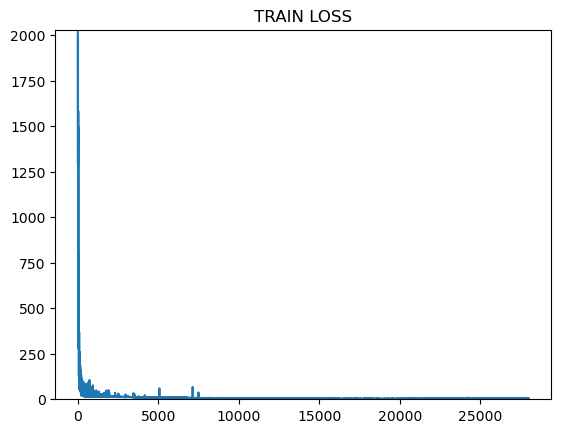

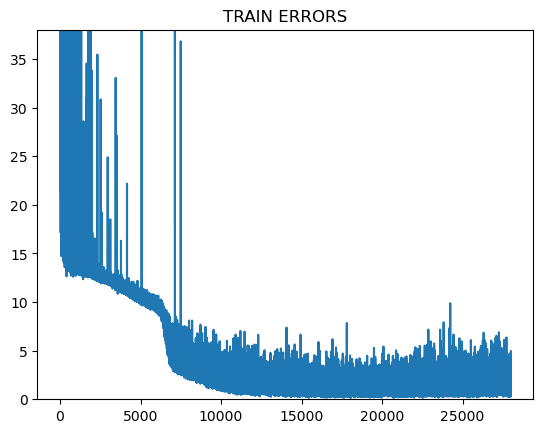

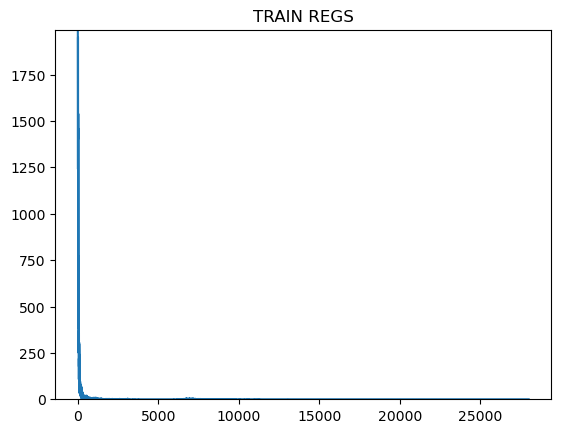

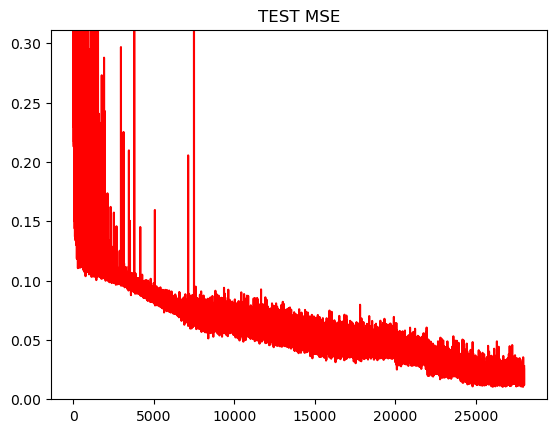

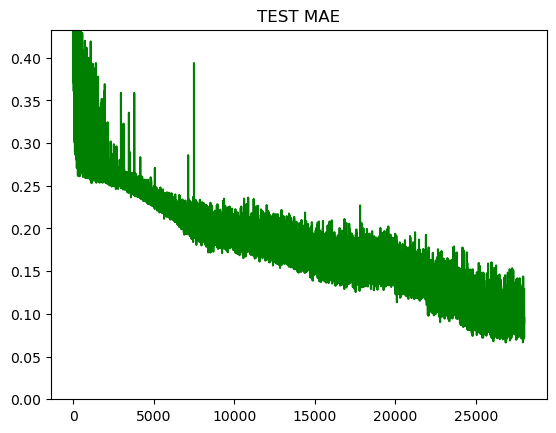

In [24]:
max_idx = 0

plt.figure()
plt.plot(train_losses)
plt.title("TRAIN LOSS")
plt.ylim(0., train_losses[max_idx])
plt.show()

plt.figure()
plt.plot(train_errors)
plt.title("TRAIN ERRORS")
plt.ylim(0., train_errors[max_idx])
plt.show()

if REG_HYPERPARAM > 0:
    plt.figure()
    plt.plot(train_regs)
    plt.title("TRAIN REGS")
    plt.ylim(0., train_regs[max_idx])
    plt.show()

plt.figure()
plt.plot(test_mses, color='r')
plt.title("TEST MSE")
plt.ylim(0., test_mses[max_idx])
plt.show()

plt.figure()
plt.plot(test_maes, color='g')
plt.title("TEST MAE")
plt.ylim(0, test_maes[max_idx])
plt.show()

In [25]:
print("Final Test MSE: ", test_mses[-1])
print("Best Test MSE: ", np.min(test_mses))
print("Best Test MSE Iteration: ", np.argmin(test_mses))

Final Test MSE:  0.02779635414481163
Best Test MSE:  0.010508657433092594
Best Test MSE Iteration:  26053


In [26]:
# Make the VF Solution and use it as input to network
import VF.vectorfit
import os

LENGTH = len(gt_freqs)

cn = str(CHIP_NUM) if CHIP_NUM > 9 else "0" + str(CHIP_NUM)
fname = os.path.join(ROOT_PATH, "case"+cn)

children = os.listdir(fname)
children = [f for f in children if cn + ".s" in f]

final_path = os.path.join(fname, children[0])

print(final_path)

fitter = VF.vectorfit.VectorFitter(final_path)
print(y_freqs)
fit1 = fitter.vector_fit("VF Result", y_freqs) 
vf_output = fit1.fitted_network.s
print(vf_output.shape)
print(vf_output.dtype)
vf_data = np.stack((vf_output.real, vf_output.imag), axis=-1)
vf_data = utils.matrix_to_sparams(vf_data)
vf_data = torch.tensor(vf_data).view(1, -1, LENGTH)
vf_data = vf_data.to(device)
print(vf_data.shape)

/scratch/cluster/bodeng/UTAFSDataNew/new_data/case05/case05.s4p
[1.0000000e+06 2.2208890e+09 6.6606670e+09 9.2205390e+09 1.1100445e+10
 1.5540223e+10 1.7220139e+10 1.8520074e+10 1.9520024e+10 2.0000000e+10]
Performing fit with 1 poles.
  Fitting took 0.018630798906087875 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
Performing fit with 2 poles.


/u/bodeng/CurveFitting-DIP/dropout_sampling/../VF/vectorfit.py:227: RuntimeWarning: Replacing d_res solution as it was too small. This is not a good sign and probably means that more starting poles are required
  vf.vector_fit(n_poles_cmplx=n_poles)
/u/bodeng/CurveFitting-DIP/dropout_sampling/../VF/vectorfit.py:227: UserWarning: The fitted network is passive, but the vector fit is not passive. Consider running `passivity_enforce()` to enforce passivity before using this model.
  vf.vector_fit(n_poles_cmplx=n_poles)


  Fitting took 0.08702747523784637 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
  Fit with 4 poles better than 3 (err 0.00036108990600671685 vs 0.004933625431786163)
Fit completed in 0.4953126907348633, using 2, resulting in a fit with 4 and error=0.00036108990600671685 vs samples and error=0.0003799087270769921 vs ground truth.
(1001, 4, 4)
complex128
torch.Size([1, 20, 1001])


In [27]:
## Make neworks from DIP, Interp, and Observations
DIP_OUT_MATRIX = utils.sparams_to_matrix(out)
VF_MATRIX = utils.sparams_to_matrix(vf_data)
Y_MATRIX = utils.sparams_to_matrix(y)

print(DIP_OUT_MATRIX.shape)
print(VF_MATRIX.shape)
print(Y_MATRIX.shape)

DIP_net = utils.matrix_to_network(DIP_OUT_MATRIX, gt_freqs, "DIP Recon With "+str(M)+" Samples for Chip "+str(CHIP_NUM))
VF_net = utils.matrix_to_network(VF_MATRIX, gt_freqs, "Vector Fit With "+str(M)+" Samples for Chip "+str(CHIP_NUM))
Y_net = utils.matrix_to_network(Y_MATRIX, y_freqs, "Observations for Chip "+str(CHIP_NUM))

DIP_FINAL_OUT = np.stack((DIP_net.s.real, DIP_net.s.imag), axis=-1)
VF_FINAL_OUT = np.stack((VF_net.s.real, VF_net.s.imag), axis=-1)

print(DIP_FINAL_OUT.shape)
print(VF_FINAL_OUT.shape)

dip_data = utils.matrix_to_sparams(DIP_FINAL_OUT)
vf_data_mat = utils.matrix_to_sparams(VF_FINAL_OUT)

print(dip_data.shape)
print(vf_data_mat.shape)
print(dip_data.dtype)
print(vf_data_mat.dtype)

## Compare DIP, VF, and Interp
import skimage.metrics
from skimage.metrics import peak_signal_noise_ratio as psnr

psnr_ours = psnr(gt_data, dip_data)
psnr_vf = psnr(gt_data, vf_data_mat)
print("DIP PSNR:      ", psnr_ours)
print("VF PSNR:       ", psnr_vf)

# print("Final DIP MSE: ", test_mses[-1])
print("Mean DIP MSE: ", nn.MSELoss()(out.to(device), x).item())
print("VF MSE:        ", nn.MSELoss()(vf_data, x).item())

torch.Size([1001, 4, 4, 2])
torch.Size([1001, 4, 4, 2])
torch.Size([10, 4, 4, 2])
(1001, 4, 4, 2)
(1001, 4, 4, 2)
(10, 2, 1001)
(10, 2, 1001)
float32
float32
DIP PSNR:       25.97297073852696
VF PSNR:        53.157378621298065
Mean DIP MSE:  0.010110273957252502
VF MSE:         1.933401836140547e-05


(1001,)
torch.Size([1, 20, 1001])
torch.Size([1, 20, 1001])
torch.Size([1, 20, 10])
torch.Size([1, 20, 1001])
torch.Size([1, 20, 1001])


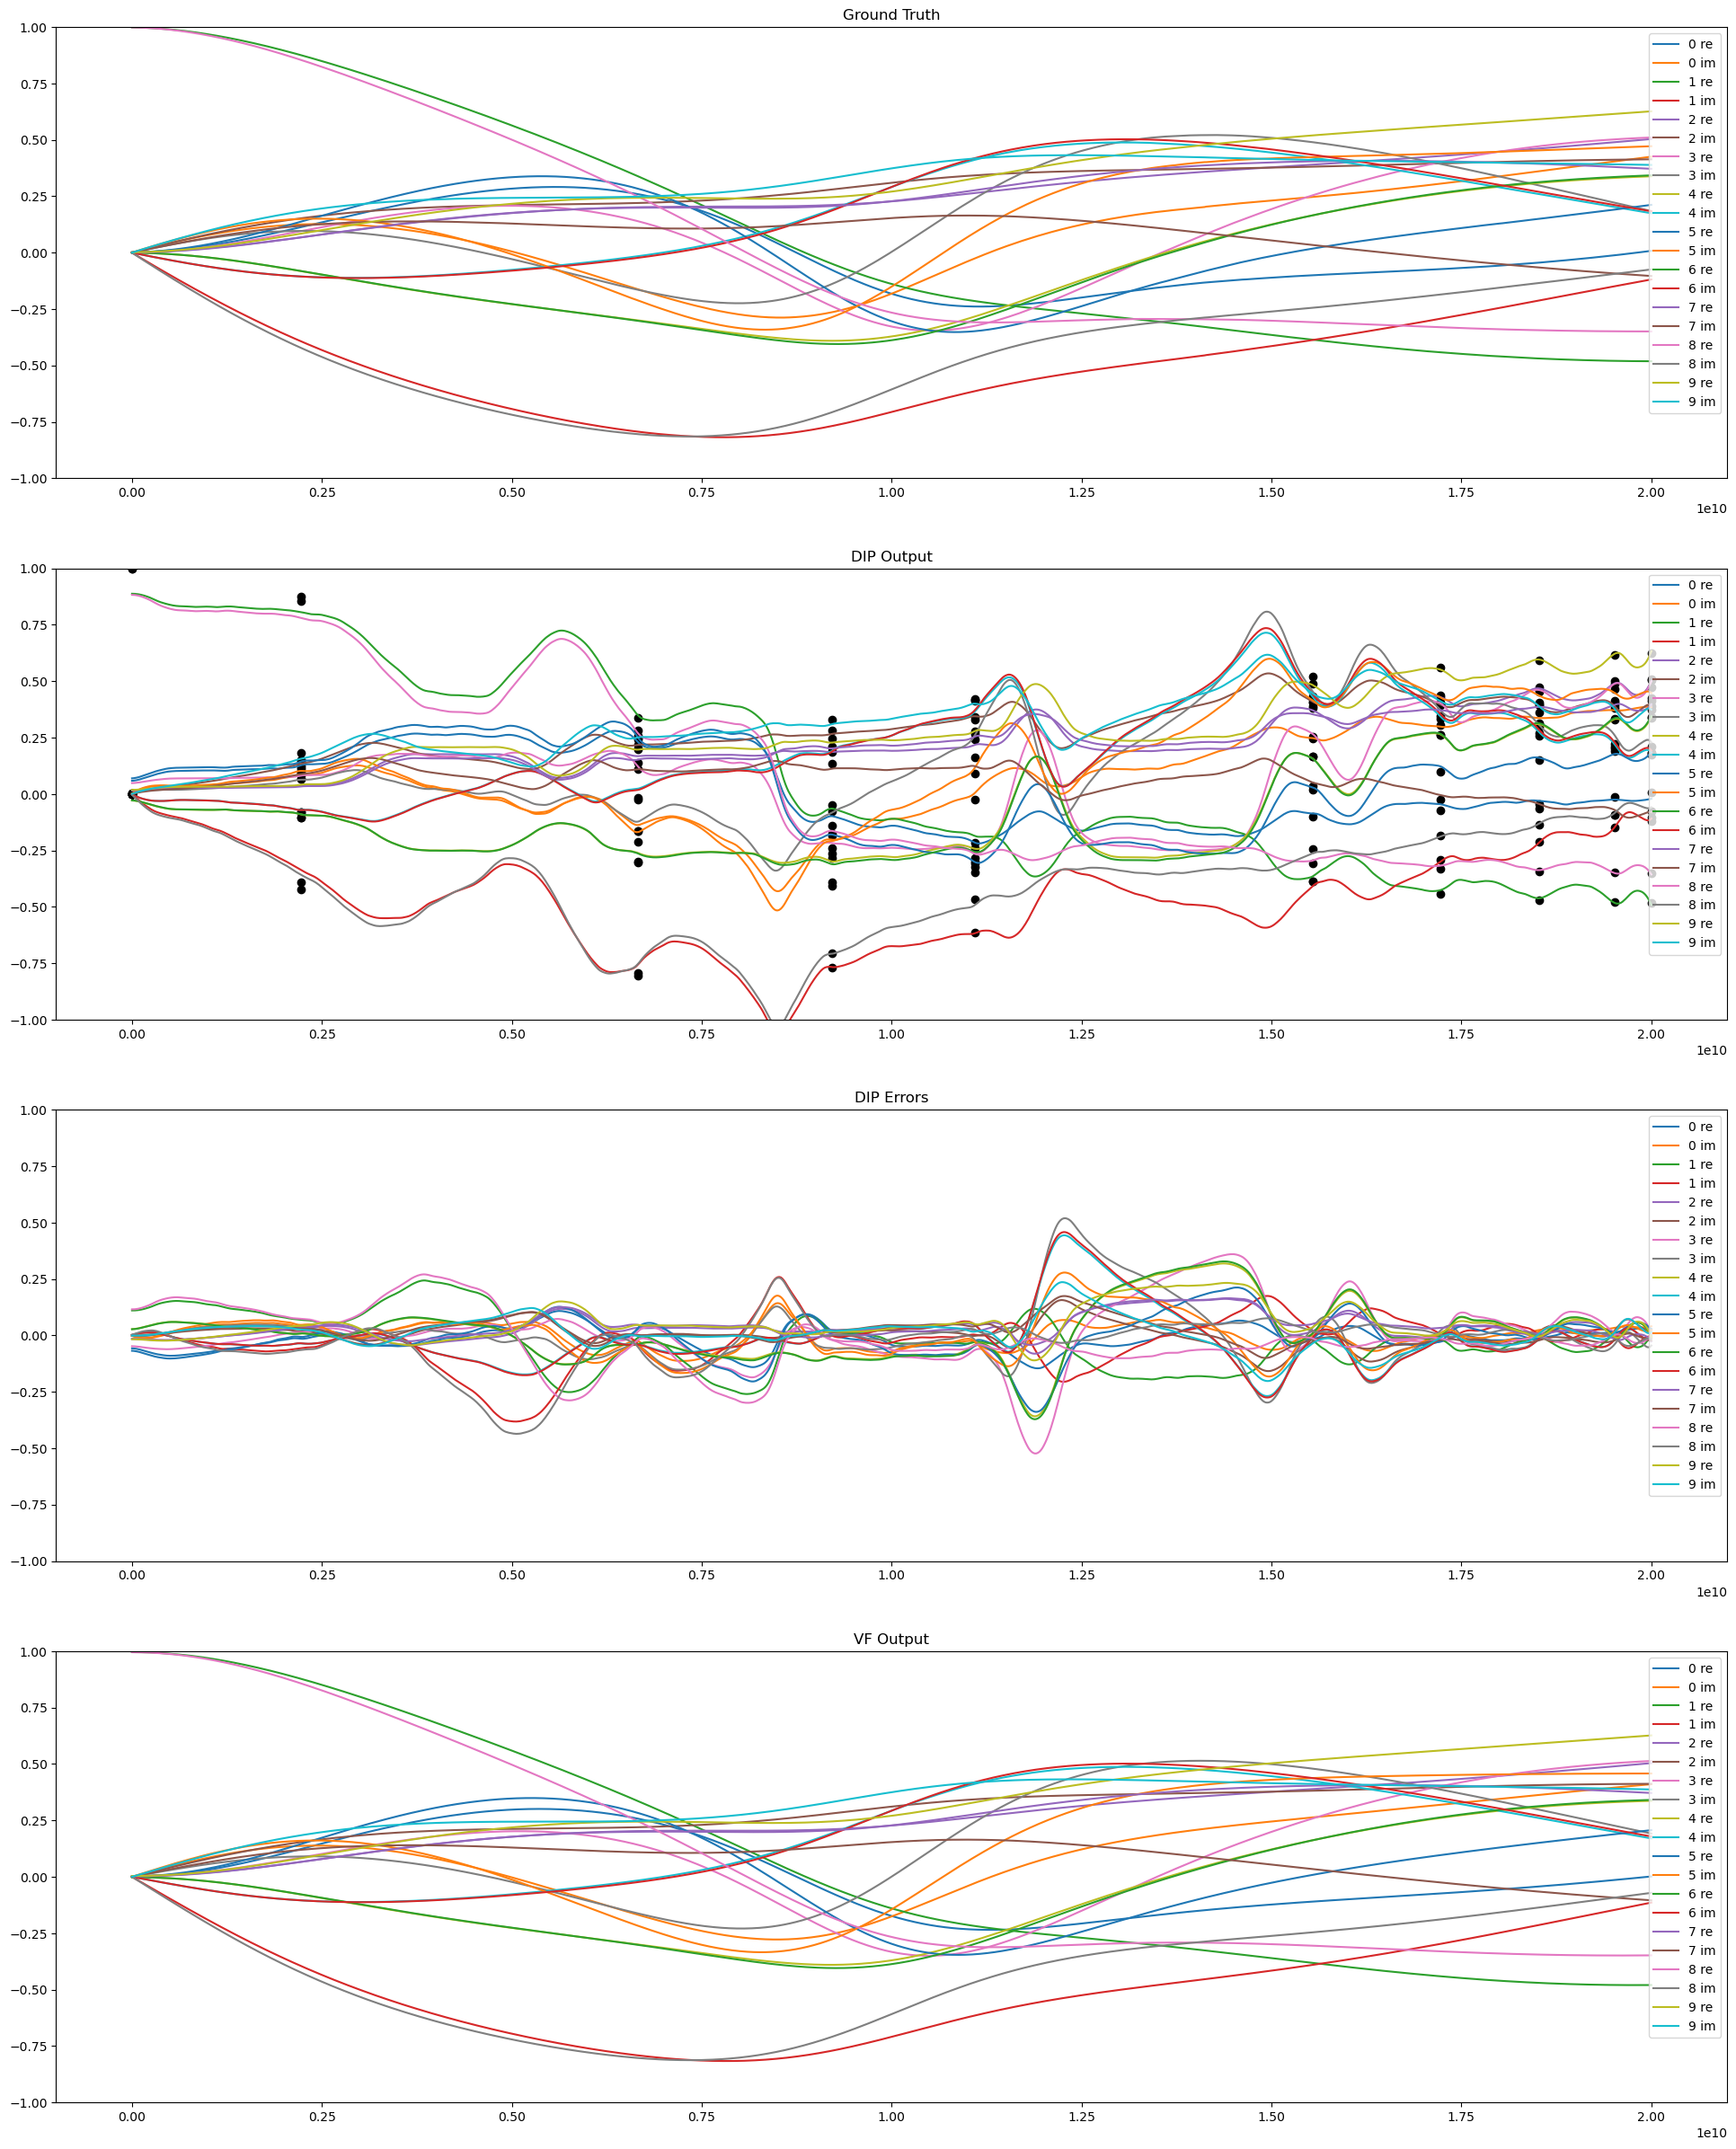

In [28]:
dip_errors = x.detach().cpu() - out.detach().cpu()
print(gt_freqs.shape)
print(out.shape)
print(dip_errors.shape)
print(y.shape)

print(out.shape)
print(vf_data.shape)

fig, axes = plt.subplots(4,1, figsize=(24, 30))
axes = axes.flatten()

for i in range(N_SPARAMS):
    axes[0].plot(gt_freqs, x[0,2*i].cpu(), label=str(i)+" re")
    axes[0].plot(gt_freqs, x[0,2*i+1].cpu(), label=str(i)+" im")
axes[0].set_title("Ground Truth")
axes[0].set_ylim(-1,1)
if N_SPARAMS <= 10:
    axes[0].legend(loc='upper right')

# SHOW WITH MEAN AND STD DEVS
# for i in range(N_SPARAMS):

#     axes[1].plot(gt_freqs, sgld_means_by_sample[-1][2*i].detach().cpu(), label=str(i)+" re")
#     axes[1].plot(gt_freqs, sgld_means_by_sample[-1][2*i+1].detach().cpu(), label=str(i)+" im")
#     axes[1].fill_between(gt_freqs, sgld_means_by_sample[-1][2*i].detach().cpu() - 2 * sgld_stds_by_sample[-1][2*i].detach().cpu(), sgld_means_by_sample[-1][2*i].detach().cpu() + 2 * sgld_stds_by_sample[-1][2*i].detach().cpu())
#     axes[1].fill_between(gt_freqs, sgld_means_by_sample[-1][2*i+1].detach().cpu() - 2 * sgld_stds_by_sample[-1][2*i+1].detach().cpu(), sgld_means_by_sample[-1][2*i+1].detach().cpu() + 2 * sgld_stds_by_sample[-1][2*i+1].detach().cpu())

#     # axes[1].scatter(gt_freqs[kept_inds], y[0,2*i].cpu(), color='black')
#     # axes[1].scatter(gt_freqs[kept_inds], y[0,2*i+1].cpu(), color='black')


# axes[1].set_title("DIP Output")
# axes[1].set_ylim(-1,1)
# if N_SPARAMS <= 10:
#     axes[1].legend(loc='upper right')

for i in range(N_SPARAMS):
    axes[1].plot(gt_freqs, out[0,2*i].detach().cpu(), label=str(i)+" re")
    axes[1].plot(gt_freqs, out[0,2*i+1].detach().cpu(), label=str(i)+" im")
    # axes[1].fill_between(gt_freqs, mean_forward_pass_outputs[0,2*i].detach().cpu() - 2 * std_forward_pass_outputs[0,2*i].detach().cpu(), mean_forward_pass_outputs[0,2*i].detach().cpu() - 2 * std_forward_pass_outputs[0,2*i].detach().cpu())
    # axes[1].fill_between(gt_freqs, mean_forward_pass_outputs[0,2*i+1].detach().cpu() - 2 * std_forward_pass_outputs[0,2*i+1].detach().cpu(), mean_forward_pass_outputs[0,2*i].detach().cpu() - 2 * std_forward_pass_outputs[0,2*i].detach().cpu())

    axes[1].scatter(gt_freqs[kept_inds], y[0,2*i].cpu(), color='black')
    axes[1].scatter(gt_freqs[kept_inds], y[0,2*i+1].cpu(), color='black')

axes[1].set_title("DIP Output")
axes[1].set_ylim(-1,1)
if N_SPARAMS <= 10:
    axes[1].legend(loc='upper right')

for i in range(N_SPARAMS):
    axes[2].plot(gt_freqs, dip_errors[0,2*i].detach().cpu(), label=str(i)+" re")
    axes[2].plot(gt_freqs, dip_errors[0,2*i+1].detach().cpu(), label=str(i)+" im")
axes[2].set_title("DIP Errors")
axes[2].set_ylim(-1,1)
if N_SPARAMS <= 10:
    axes[2].legend(loc='upper right')

for i in range(N_SPARAMS):
    axes[3].plot(gt_freqs, vf_data[0,2*i].detach().cpu(), label=str(i)+" re")
    axes[3].plot(gt_freqs, vf_data[0,2*i+1].detach().cpu(), label=str(i)+" im")
axes[3].set_title("VF Output")
axes[3].set_ylim(-1,1)
if N_SPARAMS <= 10:
    axes[3].legend(loc='upper right')

In [29]:
torch.set_printoptions(threshold=100000)
print(sgld_stds_by_sample[-1])

tensor([[5.2794e-02, 5.2884e-02, 5.3066e-02, 5.3342e-02, 5.3701e-02, 5.4015e-02,
         5.4313e-02, 5.4487e-02, 5.4593e-02, 5.4640e-02, 5.4595e-02, 5.4421e-02,
         5.4207e-02, 5.4059e-02, 5.3938e-02, 5.3860e-02, 5.3796e-02, 5.3766e-02,
         5.3778e-02, 5.3866e-02, 5.4049e-02, 5.4329e-02, 5.4707e-02, 5.5169e-02,
         5.5586e-02, 5.5852e-02, 5.5958e-02, 5.5965e-02, 5.5866e-02, 5.5741e-02,
         5.5589e-02, 5.5504e-02, 5.5473e-02, 5.5468e-02, 5.5492e-02, 5.5479e-02,
         5.5422e-02, 5.5334e-02, 5.5211e-02, 5.5094e-02, 5.4983e-02, 5.4865e-02,
         5.4740e-02, 5.4648e-02, 5.4590e-02, 5.4613e-02, 5.4717e-02, 5.4851e-02,
         5.5014e-02, 5.5216e-02, 5.5454e-02, 5.5647e-02, 5.5794e-02, 5.5880e-02,
         5.5904e-02, 5.5877e-02, 5.5797e-02, 5.5754e-02, 5.5750e-02, 5.5816e-02,
         5.5954e-02, 5.6138e-02, 5.6366e-02, 5.6591e-02, 5.6812e-02, 5.6977e-02,
         5.7087e-02, 5.7092e-02, 5.6992e-02, 5.6910e-02, 5.6849e-02, 5.6844e-02,
         5.6892e-02, 5.6931e

In [30]:
print(dip_errors[-1])

tensor([[-5.7305e-02, -5.7642e-02, -5.8440e-02, -5.9503e-02, -6.0779e-02,
         -6.2401e-02, -6.4341e-02, -6.6265e-02, -6.8182e-02, -7.0040e-02,
         -7.1843e-02, -7.3724e-02, -7.5674e-02, -7.7534e-02, -7.9357e-02,
         -8.1027e-02, -8.2495e-02, -8.3816e-02, -8.4956e-02, -8.6063e-02,
         -8.7146e-02, -8.8107e-02, -8.8967e-02, -8.9640e-02, -9.0052e-02,
         -9.0221e-02, -9.0153e-02, -9.0037e-02, -8.9839e-02, -8.9470e-02,
         -8.8935e-02, -8.8403e-02, -8.7875e-02, -8.7232e-02, -8.6473e-02,
         -8.5758e-02, -8.5068e-02, -8.4395e-02, -8.3762e-02, -8.3156e-02,
         -8.2562e-02, -8.1883e-02, -8.1125e-02, -8.0293e-02, -7.9386e-02,
         -7.8514e-02, -7.7675e-02, -7.6797e-02, -7.5879e-02, -7.4989e-02,
         -7.4132e-02, -7.3155e-02, -7.2067e-02, -7.0933e-02, -6.9739e-02,
         -6.8382e-02, -6.6861e-02, -6.5406e-02, -6.4018e-02, -6.2672e-02,
         -6.1375e-02, -6.0232e-02, -5.9243e-02, -5.8624e-02, -5.8371e-02,
         -5.8043e-02, -5.7639e-02, -5.

In [31]:
out_mag = utils.sparams_to_mag(out)
dip_errors_mag = x_mag - out_mag 

fig, axes = plt.subplots(3,1, figsize=(16, 12))
axes = axes.flatten()

for i in range(N_SPARAMS):
    axes[0].plot(gt_freqs, x_mag[0,i].cpu(), label=str(i))
axes[0].set_title("Ground Truth Magnitude Spectrum")
axes[0].set_ylim(0,1)
if N_SPARAMS <= 10:
    axes[0].legend()

for i in range(N_SPARAMS):
    axes[1].plot(gt_freqs, out_mag[0,i].detach().cpu(), label=str(i))
axes[1].set_title("DIP Output Magnitude Spectrum")
axes[1].set_ylim(0,1)
if N_SPARAMS <= 10:
    axes[1].legend()
    
for i in range(N_SPARAMS):
    axes[2].plot(gt_freqs, dip_errors[0,i].detach().cpu(), label=str(i))
axes[2].set_title("DIP Errors Magnitude Spectrum")
axes[2].set_ylim(-1,1)
if N_SPARAMS <= 10:
    axes[2].legend()

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

In [ ]:
print(kept_inds)

[  0  15  44  61 133 223 312 339 380 401 404 490 529 580]
